In [3]:
! gdown https://drive.google.com/u/3/uc?id=1-52ga1hIGY-_2cIaS-gRmWkt14BJOxO9

Downloading...
From: https://drive.google.com/u/3/uc?id=1-52ga1hIGY-_2cIaS-gRmWkt14BJOxO9
To: /content/jimutmap_less.zip
926MB [00:07, 123MB/s]


In [4]:
! unzip -qq jimutmap_less.zip

In [5]:
#! unzip -qq roads.zip
import os
import numpy as np
import cv2
from glob import glob
import tensorflow as tf
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split

from tensorflow.keras.layers import Conv2D, Activation, BatchNormalization
from tensorflow.keras.layers import UpSampling2D, Input, Concatenate
from tensorflow.keras.models import Model , load_model
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from keras.layers import Input, Conv2D, MaxPooling2D, Conv2DTranspose, concatenate, BatchNormalization, Activation, add
from tensorflow.keras.metrics import Recall, Precision 
from tensorflow.keras import backend as K


In [6]:
import glob
images_list = sorted(glob.glob("jimutmap_less/map/*"))
masks_list = sorted(glob.glob("jimutmap_less/roads/*"))
print(images_list[:10])
print(len(images_list))
print(len(masks_list))
print(masks_list[:10])

['jimutmap_less/map/390303_227867.jpeg', 'jimutmap_less/map/390303_227888.jpeg', 'jimutmap_less/map/390303_228064.jpeg', 'jimutmap_less/map/390303_228073.jpeg', 'jimutmap_less/map/390303_228076.jpeg', 'jimutmap_less/map/390303_228185.jpeg', 'jimutmap_less/map/390303_228357.jpeg', 'jimutmap_less/map/390303_228378.jpeg', 'jimutmap_less/map/390303_228380.jpeg', 'jimutmap_less/map/390303_228397.jpeg']
61950
61950
['jimutmap_less/roads/390303_227867_road.png', 'jimutmap_less/roads/390303_227888_road.png', 'jimutmap_less/roads/390303_228064_road.png', 'jimutmap_less/roads/390303_228073_road.png', 'jimutmap_less/roads/390303_228076_road.png', 'jimutmap_less/roads/390303_228185_road.png', 'jimutmap_less/roads/390303_228357_road.png', 'jimutmap_less/roads/390303_228378_road.png', 'jimutmap_less/roads/390303_228380_road.png', 'jimutmap_less/roads/390303_228397_road.png']


In [7]:
import os
from tqdm import tqdm

for img_fl in tqdm(images_list[:45975]):
  try:
    os.remove(img_fl)
    #print(img_fl)
    mask_name = "jimutmap_less/roads/"+str(img_fl.split('.')[0]).split('/')[-1]+"_road.png"
    os.remove(mask_name)
    #break
  except:
    pass

100%|██████████| 45975/45975 [00:02<00:00, 15583.82it/s]


In [8]:
from glob import glob
def load_data(path, split=0.1):

  images_list = sorted(glob(os.path.join(path, "jimutmap_less/map/*")))
  masks_list = sorted(glob(os.path.join(path, "jimutmap_less/roads/*")))

  tot_size = len(images_list)
  val_size = int(split * tot_size)
  test_size = int(split * tot_size)

  x_train, x_val = train_test_split(images_list, test_size=val_size, random_state=42)
  y_train, y_val = train_test_split(masks_list, test_size=val_size, random_state=42)
  x_train, x_test = train_test_split(x_train, test_size=test_size, random_state=42)
  y_train, y_test = train_test_split(y_train, test_size=test_size, random_state=42)

  return (x_train, y_train), (x_val, y_val), (x_test, y_test)

In [9]:

def read_img(path):
    path = path.decode()
    tmp = cv2.imread(path, cv2.IMREAD_COLOR)
    tmp = cv2.resize(tmp, (IMG_SIZE, IMG_SIZE))
    tmp = tmp/255.0
    return tmp



def read_mask(path):
    path = path.decode()
    tmp = cv2.imread(path, cv2.IMREAD_GRAYSCALE)
    tmp = cv2.resize(tmp, (IMG_SIZE, IMG_SIZE))
    tmp = tmp/255.0
    tmp = np.expand_dims(tmp, axis=-1)
    return tmp


In [10]:
def tf_parse(a, b):
    def _parse(a, b):
        a = read_img(a)
        b = read_mask(b)
        return a, b

    a, b = tf.numpy_function(_parse, [a, b], [tf.float64, tf.float64])
    a.set_shape([IMG_SIZE, IMG_SIZE, 3])
    b.set_shape([IMG_SIZE, IMG_SIZE, 1])
    return a, b

def tf_dataset(a, b, batch=32):
    data = tf.data.Dataset.from_tensor_slices((a, b))
    data = data.map(tf_parse)
    data = data.batch(batch)
    data = data.repeat()
    return data

In [11]:

(x_train, y_train), (x_val, y_val), (x_test, y_test) = load_data("")

print("Training data: ", len(x_train))
print("Validation data: ", len(x_val))
print("Testing data: ", len(x_test))

Training data:  12781
Validation data:  1597
Testing data:  1597


In [12]:
def read_and_rgb(a):
    a = cv2.imread(a)
    a = cv2.cvtColor(a, cv2.COLOR_BGR2RGB)
    return a

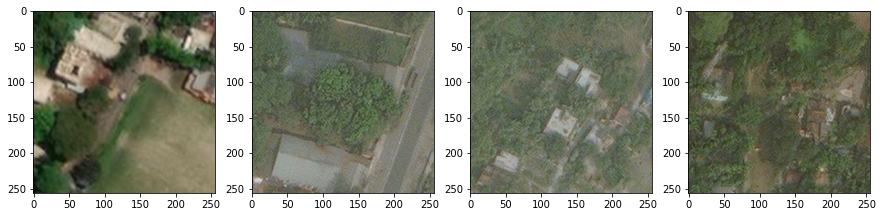

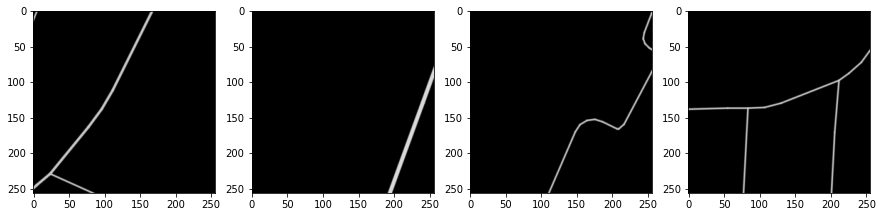

In [13]:
fig = plt.figure(figsize=(15, 15))
x = fig.add_subplot(1, 4, 1)
imgplot = plt.imshow(read_and_rgb(x_train[0]))

x = fig.add_subplot(1, 4, 2)
imgplot = plt.imshow(read_and_rgb(x_train[1]))
imgplot.set_clim(0.0, 0.7)

x = fig.add_subplot(1, 4, 3)
imgplot = plt.imshow(read_and_rgb(x_train[2]))
imgplot.set_clim(0.0, 1.4)

x = fig.add_subplot(1, 4, 4)
imgplot = plt.imshow(read_and_rgb(x_train[3]))
imgplot.set_clim(0.0, 2.1)

fig = plt.figure(figsize=(15, 15))
x = fig.add_subplot(1, 4, 1)
imgplot = plt.imshow(read_and_rgb(y_train[0]))

x = fig.add_subplot(1, 4, 2)
imgplot = plt.imshow(read_and_rgb(y_train[1]))
imgplot.set_clim(0.0, 0.7)

x = fig.add_subplot(1, 4, 3)
imgplot = plt.imshow(read_and_rgb(y_train[2]))
imgplot.set_clim(0.0, 1.4)

x = fig.add_subplot(1, 4, 4)
imgplot = plt.imshow(read_and_rgb(y_train[3]))
imgplot.set_clim(0.0, 1.4)

In [14]:
IMG_SIZE = 256

In [15]:
def model():
    inputs = Input(shape=(IMG_SIZE, IMG_SIZE, 3), name="input_image")
    
    encoder = MobileNetV2(input_tensor=inputs, weights="imagenet", include_top=False, alpha=0.50)
    skip_connection_list = ["input_image", "block_1_expand_relu", "block_3_expand_relu", "block_6_expand_relu"]
    encoder_output = encoder.get_layer("block_13_expand_relu").output
    
    fil = [48, 64, 96, 128]
    xt = encoder_output
    for i in range(1, len(skip_connection_list)+1, 1):
        xt_skip = encoder.get_layer(skip_connection_list[-i]).output
        xt = UpSampling2D((2, 2))(xt)
        xt = Concatenate()([xt, xt_skip])
        
        xt = Conv2D(fil[-i], (3, 3), padding="same")(xt)
        xt = BatchNormalization()(xt)
        xt = Activation("relu")(xt)
        
        xt = Conv2D(fil[-i], (3, 3), padding="same")(xt)
        xt = BatchNormalization()(xt)
        xt = Activation("relu")(xt)
        
    xt = Conv2D(1, (1, 1), padding="same")(xt)
    xt = Activation("sigmoid")(xt)
    
    model = Model(inputs, xt)
    return model

In [16]:
model = model()
model.summary()

3203072/3201480 [==============================] - 0s 0us/step
Model: "functional_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_image (InputLayer)        [(None, 256, 256, 3) 0                                            
__________________________________________________________________________________________________
Conv1_pad (ZeroPadding2D)       (None, 257, 257, 3)  0           input_image[0][0]                
__________________________________________________________________________________________________
Conv1 (Conv2D)                  (None, 128, 128, 16) 432         Conv1_pad[0][0]                  
__________________________________________________________________________________________________
bn_Conv1 (BatchNormalization)   (None, 128, 128, 16) 64          Conv1[0][0]                      
________________________

In [17]:
smooth = 1e-15
def dice_coef(y_true, y_pred):
    y_true = tf.keras.layers.Flatten()(y_true)
    y_pred = tf.keras.layers.Flatten()(y_pred)
    intersection = tf.reduce_sum(y_true * y_pred)
    return (2. * intersection + smooth) / (tf.reduce_sum(y_true) + tf.reduce_sum(y_pred) + smooth)

def dice_loss(y_true, y_pred):
    return 1.0 - dice_coef(y_true, y_pred)

In [20]:
# Run this module only while loading the pre-trained model.
model = load_model('JimutmapRoads_with_weight_10e_lr05.h5',custom_objects={'dice_loss': dice_loss,'dice_coef':dice_coef})
model.summary()


Model: "functional_3"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_image (InputLayer)        [(None, 256, 256, 3) 0                                            
__________________________________________________________________________________________________
Conv1_pad (ZeroPadding2D)       (None, 257, 257, 3)  0           input_image[0][0]                
__________________________________________________________________________________________________
Conv1 (Conv2D)                  (None, 128, 128, 16) 432         Conv1_pad[0][0]                  
__________________________________________________________________________________________________
bn_Conv1 (BatchNormalization)   (None, 128, 128, 16) 64          Conv1[0][0]                      
_______________________________________________________________________________________

In [22]:
def read_img(path):
    xt = cv2.imread(path, cv2.IMREAD_COLOR)
    xt = cv2.cvtColor(xt, cv2.COLOR_BGR2RGB)
    xt = cv2.resize(xt, (IMG_SIZE, IMG_SIZE))
    xt = xt/255.0
    return xt

def read_mask(path):
    xt = cv2.imread(path, cv2.IMREAD_GRAYSCALE)
    xt = cv2.resize(xt, (IMG_SIZE, IMG_SIZE))
    xt = np.expand_dims(xt, axis=-1)
    xt = xt/255.0
    return xt

def mask_parse(mask):
    mask = np.squeeze(mask)
    mask = [mask, mask, mask]
    mask = np.transpose(mask, (1, 2, 0))
    return mask

In [24]:
! mkdir results

In [27]:
for i, (a, b) in enumerate(zip(x_test[10:30], y_test[10:30])):
    a = read_img(a)
    b = read_mask(b)
    y_pred = model.predict(np.expand_dims(a, axis=0))[0] > 0.5
    #print(y_pred.shape)
    h, w, _ = a.shape
    white_line = np.ones((h, 10, 3))
    mask_red = np.ones((h,w,3))
    # mask_red[:,:,0] = a[:,:,0]*.5
    # mask_red[:,:,1] = a[:,:,1]*0.5 
    mask_red[:,:,:] = y_pred[:,:,:] #+ a[:,:,2]*0.5  
    mask_red = mask_red*2
    mask_red = np.clip(mask_red, 0, 1)
    all_images = [
        a, white_line,
        mask_parse(b), white_line,
        mask_red
        #mask_parse(y_pred)*0.5+a*0.5
    ]
    image = np.concatenate(all_images, axis=1)
    fig = plt.figure(figsize=(12, 12))
    x = fig.add_subplot(1, 1, 1)
    imgplot = plt.imshow(image)
    plt.savefig('results/'+str(i)+'.png',format='png')
    plt.close()


In [28]:
! zip -r results.zip results

  adding: results/ (stored 0%)
  adding: results/19.png (deflated 6%)
  adding: results/10.png (deflated 6%)
  adding: results/11.png (deflated 8%)
  adding: results/4.png (deflated 6%)
  adding: results/17.png (deflated 5%)
  adding: results/3.png (deflated 5%)
  adding: results/15.png (deflated 6%)
  adding: results/12.png (deflated 5%)
  adding: results/7.png (deflated 5%)
  adding: results/1.png (deflated 6%)
  adding: results/9.png (deflated 6%)
  adding: results/6.png (deflated 6%)
  adding: results/13.png (deflated 5%)
  adding: results/2.png (deflated 6%)
  adding: results/18.png (deflated 6%)
  adding: results/5.png (deflated 5%)
  adding: results/14.png (deflated 5%)
  adding: results/16.png (deflated 6%)
  adding: results/0.png (deflated 6%)
  adding: results/8.png (deflated 6%)
